# EM Implementation in GMM
- for binary classification
- we will use k-fold cross-vadliation to find optimal number of cluster: **k**


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# initial setting
data_dir = './data'

In [ ]:
# read the data from txt files
# seperator : whitespace(\\s+)
train_data = pd.read_csv(os.path.join(data_dir, 'train.txt'), sep="\\s+",header=None)
train_x = train_data.iloc[:, :-1]
train_y = train_data.iloc[:, -1]

test_data = pd.read_csv(os.path.join(data_dir, 'test.txt'), sep="\\s+",header=None)
test_x = test_data.iloc[:, :-1]
test_y = test_data.iloc[:, -1]

# featrue: 13 & data counts: 60290
print(f'shape of train_x: {train_x.shape}')
print(f'missing value exist: {train_x.isnull().sum().sum() == 1}')

shape of train_x: (60290, 13)
missing value exist: False


## E-step

### Problem
1. matrix multiply has $O(n^3)$, and $Z=(x^t-\mu_k)^\top\Sigma_k^{-1}(x^t-\mu_k)$ will be takes many times to caculate.
2. If term $Z$ has big value, exponential caculate may be overflowed.

### Assume
1. It is known that covariance matrix is symmetric matrix and semi- positively-definite.
2. Then, we can use **eigen decomposition** to covariance matrix.

#### Solution
1. $\Sigma=Q{\Lambda}Q^\top$ by eigen decomposition.
2. And $\Sigma$ is symmetric, $Q^\top = Q^{-1}$ by orthogonality.
3. $\Sigma^{-1}=Q{\Lambda}^{-1}Q^\top$, and $\Lambda$ is diagonal so that we can caculate it using one dividing by each value diagonal.
4. $((x-\mu)^{\top}Q\sqrt{\Lambda^{-1}})^2$ will be same as $Z$.
5. The term of guassian probability density function will be caculated in log space.



In [4]:
def log_guassian(X:np.ndarray, cluster_k:int , theta:dict):
    N, n_features = X.shape
    weights = np.zeros((N, cluster_k)) # make w_k^t matrix

    log_pi = np.log(theta['pi'])
    norm_factor = -0.5 * np.log(2 * np.pi) * n_features

    # for logarithm calculation
    # It is known that the covariance matrix is symmetric matrix and positive definite matrix
    # Then, we can derive eigenvalue and eigenvector of the covariance matrix
    # get eigenvalue and eigenvector of the covariance matrix
    eig_vals, eig_vecs = np.linalg.eigh(theta['var'])
    # we can caculate inverse of eigenvalue from dividing by 1 : digonal matrix
    eig_val_inv = 1. / eig_vals
    log_det = -0.5 * np.sum(np.log(eig_vals),axis=1) 

    other_term  = log_det + norm_factor + log_pi

    U = eig_vecs * np.sqrt(eig_val_inv)[:, np.newaxis]
    # matrix multiply no need to transpose
    differ = X.reshape(N, 1, n_features) - theta['mean'].reshape(1, cluster_k, n_features)

    for t in range(N):
        mahas = np.zeros(cluster_k)
        for k in range(cluster_k):
            # they are in log space, so plus all term instead of multiply
            mahas[k] = -0.5 * np.sum((differ[t][k] @ U[k]) ** 2)
        weights[t] = mahas + other_term

    return weights

In [7]:
def E_step(weights: np.ndarray) -> np.ndarray:
    N = weights.shape[0]

    # we will caculate in log space, so we need to prevent overflow by exponential function
    for t in range(N):
        # make smaller exponential term by subtract max weight for preventing overflow
        logarithm_weights = np.exp(weights[t] - np.max(weights[t]))
        logarithm_weights_sum = np.sum(logarithm_weights)
        weights[t] = logarithm_weights / logarithm_weights_sum

    return weights 

## M-step
- estimate new theta for optimal weights.

### Problem
It is known that $XX^T$ is positive definite matrix,   
But numerical error can make not positive definite matrix.   
so that we need to prevent it by adding small value to diagonal element.   

If not, we can't calculate inverse of the matrix.
Also, det of the covariance matrix may be 0

### Solution
Add diagonal very small value, to prevent det of covariance matrix is under 0

In [8]:
def M_step(x: np.ndarray, weights: np.ndarray, cluster_k: int) -> dict:
    n_feature = x.shape[1]
    N = x.shape[0]

    # just for make theta dictionary, not related to the initialzation
    theta = {
        'pi' : np.zeros(cluster_k),
        'mean': np.zeros((cluster_k, n_feature)),
        'var': np.array([np.eye(n_feature)] * cluster_k)
    }

    # sum of weight for each cluster index:k
    weights_sum = weights.sum(axis=0)
    theta['pi'] =  weights_sum / N
    theta['mean'] = (weights.T @ x) / weights_sum.reshape(-1, 1)

    for k in range(cluster_k):
        differ = x - theta['mean'][k]
        theta['var'][k] = (weights[:, k] * differ.T) @ differ / weights_sum[k]

        """
        It is known that X@X^T is positive definite matrix,
        But numerical error can make not positive definite matrix.
        so that we need to prevent it by adding small value to diagonal element
        If not, we can't calculate inverse of the matrix.
        Also, det of the covariance matrix may be 0

        if covariance is equal to 0 or negative, we need to prevent it
        """
        theta['var'][k] += np.eye(n_feature) * 1e-10

    return theta


## EM (*Expectation Maximazation Algorithm*)


### Initialization
Just use random initialization, theta will be converged as specific parameter.

- pi : has equal value, that 1 divided by number of cluster (K)
- mean : has random value
- covariance : Identify Matrix, it guarantees symmetric-semi-positive-definite matrix.

### Terminal Condition
If diffentation of log_likelihood is enough small to less than $10^{-3}$, we consider it converged.   
(*In likelihood - log_likelihood*)


In [9]:
class EM:
    def __init__(self, n_feature: int, cluster_k: int):
        self.cluster_k = cluster_k # will be change
        self.weights = None

        # theta initialization
        self.theta = {
            'pi' : np.ones(self.cluster_k) / self.cluster_k,
            'mean': np.random.randn(self.cluster_k, n_feature),
            'var': np.array([np.eye(n_feature)] * self.cluster_k)
        }

    def fit(self, x: np.ndarray, tol: float = 1e-3):
        i = 0
        log_likelihoods = []
        while True:
            weights = log_guassian(X=x, cluster_k=self.cluster_k, theta=self.theta)
            maxes = np.max(weights, axis=1).reshape(-1, 1)

            log_likelihood = np.log(np.exp(weights - maxes).sum(axis=1)) + maxes.flatten()
            average_likelihood = log_likelihood.mean()
            log_likelihoods.append(average_likelihood)

            if i > 0:
                differ = np.abs(log_likelihoods[-1] - log_likelihoods[-2])
                # if iteration is over 50, we can stop the iteration
                if differ < tol or i > 50:
                    break

            self.weights = E_step(weights=weights)
            self.theta = M_step(x=x, weights=self.weights, cluster_k=self.cluster_k)

            i += 1

    def predict_proba(self, x: np.ndarray, prior) -> np.ndarray:
        weights = log_guassian(X=x, cluster_k=self.cluster_k, theta=self.theta)
        maxes = np.max(weights, axis=1).reshape(-1, 1)
        weights = np.exp(weights - maxes)
        likelihood = weights.sum(axis=1)

        # It is just for compasion, so we don't need to consider evidence term (P(x))
        log_posterior =  np.log(likelihood) + np.log(prior) + maxes.flatten()
        return log_posterior

### Training and validation Procedure
Trained with k-fold train dataset, for each class (*0 or 1*).

1. Each class of data will have own guassian mixture, so we make two EM model by number of cluster count.
2. After training of parameter ($\theta, w$), we predict class of training data and validation data with likelihood.
3. Then, we can get error rate of each data. And get mean of error rate of all fold.
4. Repeat it increasing number of cluster (K)




In [10]:
class K_Fold:
    def __init__(self,n_splits: int):
        self.n_splits = n_splits

    def split(self, data: np.ndarray):
        n_data = data.shape[0]
        indices = np.arange(n_data)

        sliced = n_data // self.n_splits

        for i in range(self.n_splits):
            start = i *  sliced
            end = (i + 1) *  sliced
            yield np.concatenate((indices[:start],indices[end:])), indices[start:end], i+1

#### Training
1. Each class data has guassian mixture.
2. So, we will make two models for each guassian mixture and train.

In [11]:
def train_EM(x: np.ndarray, y: np.ndarray, cluster_k :int):
    EM_0 = EM(n_feature=x.shape[1], cluster_k=cluster_k)
    EM_1 = EM(n_feature=x.shape[1], cluster_k=cluster_k)

    EM_0.fit(x[y == 0])
    EM_1.fit(x[y == 1])

    return EM_0, EM_1

#### Prediction
1. Get Posterior of each model, and compare it.
2. Select which Posterior is bigger than other one.

In [12]:
def predict_class(EM_0: EM, EM_1: EM, prior_c0, prior_c1, x: np.ndarray) -> np.ndarray:
    posterior_0 = EM_0.predict_proba(x, prior_c0)
    posterior_1 = EM_1.predict_proba(x, prior_c1)

    return np.where(posterior_0 > posterior_1, 0, 1)

## Training with K-fold cross validation
- we will use n_splits(k) = 5
- we can get mean of validation error of each number of cluster(K), then we determine optimal number of cluter
- optimal number of cluster is considered when mean of validation error is first local minimum.

cluster_max is not required too big value.    
It just needs to be a value enough to find the local minimum.   

(*k at the point when the validation error rate is decreasing and then increasing*)

In [13]:
def GMM_train(X_train, y_train,X_val,y_val, cluster_k, prior_c0, prior_c1):
    EM_0, EM_1 = train_EM(X_train,y_train, cluster_k=cluster_k)

    y_pred_train = predict_class(EM_0= EM_0, EM_1=EM_1,prior_c0=prior_c0,prior_c1=prior_c1,x=X_train)
    train_error =(y_train != y_pred_train).mean()
    y_pred_val = predict_class(EM_0= EM_0, EM_1=EM_1,prior_c0=prior_c0,prior_c1=prior_c1,x=X_val)
    val_error=(y_val != y_pred_val).mean()

    return train_error, val_error

In [14]:
folder = K_Fold(n_splits=5) # we fix the number of splits to 5

X = train_x.to_numpy()
y = train_y.to_numpy()

prior_c0 = train_y.value_counts()[0] / train_y.shape[0]
prior_c1 = train_y.value_counts()[1] / train_y.shape[0]
print(f'Prior of class ========\nc0: {prior_c0}, c1: {prior_c1}\n')

k_train_errors = []
k_val_errors = []

cluster_max = 15

print('Training EM algorithm with different cluster number =================================')
for k in range(2, cluster_max + 1):
    print(f'cluster number: {k} ================================')

    train_errors = []
    val_errors = []
    for train_index, test_index, index in folder.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        print(f'{index} fold is training...')

        train_error, val_error = GMM_train(X_train,y_train, X_val,y_val, k, prior_c0, prior_c1)
        train_errors.append(train_error)
        val_errors.append(val_error)

    k_train_errors.append(np.mean(train_errors))
    k_val_errors.append(np.mean(val_errors))

    print(f'fold error - training: {k_train_errors[-1]} & validation: {k_val_errors[-1]}')
    print(f'cluster number: {k} is done\n')

Prior of class ========
c0: 0.4521811245646044, c1: 0.5478188754353955

Training EM algorithm with different cluster number =================================
cluster number: 2 ================================
1 fold is training...
2 fold is training...
3 fold is training...
4 fold is training...
5 fold is training...
fold error - training: 0.15754685685851716 & validation: 0.15873279150771274
cluster number: 2 is done

cluster number: 3 ================================
1 fold is training...
2 fold is training...
3 fold is training...
4 fold is training...
5 fold is training...
fold error - training: 0.15369464256095539 & validation: 0.15655996019240337
cluster number: 3 is done

cluster number: 4 ================================
1 fold is training...
2 fold is training...
3 fold is training...
4 fold is training...
5 fold is training...
fold error - training: 0.1518203682202687 & validation: 0.15329241997014428
cluster number: 4 is done

cluster number: 5 ==============================

### Graph for training error and Validation Error
- find optimal number of cluster : **K**
- k of local minimum will be optimal number of cluster.

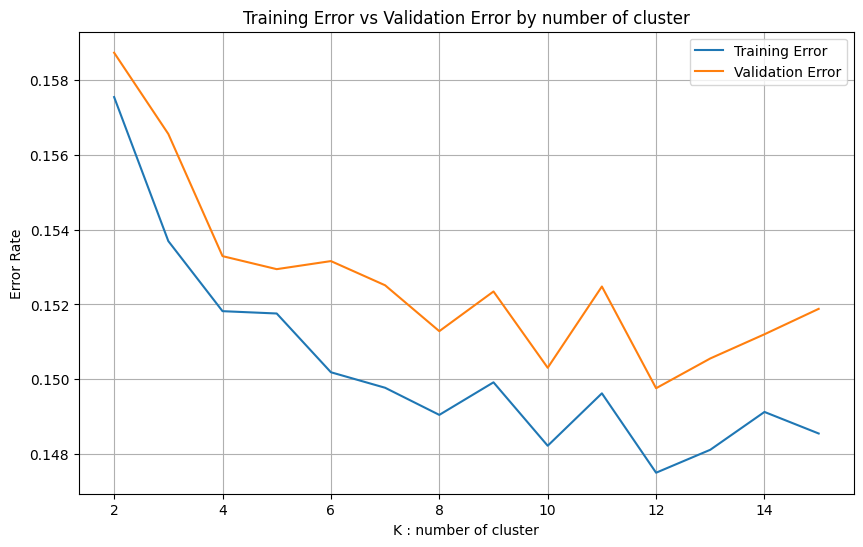

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, cluster_max+1), k_train_errors, label='Training Error')
plt.plot(range(2, cluster_max+1), k_val_errors, label='Validation Error')
plt.xlabel('K : number of cluster')
plt.ylabel('Error Rate')
plt.title('Training Error vs Validation Error by number of cluster')
plt.legend()
plt.grid(True)
plt.show()

## Test Procedure
Now, just get error rate of test data.

It will be measured with optimal number of Cluster model, that is trained with train data.

In [17]:
cluster_k = 12 # it is local minumum point
print(f'Training for optimal cluster number: {cluster_k}')
test_model0, test_model1 = train_EM(train_x.to_numpy(), train_y.to_numpy(), cluster_k)
print(f'Training done!')

pred = predict_class(test_model0, test_model1, prior_c0, prior_c1, test_x.to_numpy())
test_error_rate = np.mean(test_y != pred)

print(f'test error rate: {test_error_rate}')

Training for optimal cluster number: 12
Training done!
test error rate: 0.14919555481837785
